# Example 1: Identification of a Nonlinear System Using a Series-Parallel Model


## Problem Summary
**Goal:** Identify a nonlinear function `f(u)` in a system that is represented by the equation:
  
$y_p(k + 1) = 0.3 y_p(k) + 0.6 y_p(k - 1) + f(u(k))$

Where

$f(u) = 0.6 \sin(\pi u) + 0.3 \sin(3\pi u) + 0.1 \sin(5\pi u)$

and $k$ is the length of the input signal and $u(k) = \sin(\frac{2\pi k}{250})$ is the input signal.

## Implementation Steps
**Approach:** Use a neural network $N(u)$ to approximate the unknown function $f(u)$ based on input-output data.

**Initial Conditions:** $y_{p}(0)$ and $y_{p}(1)$ are unknown, they are initialized to zero.


1. **Data Preparation**: Generate sequences $u(k)$ and $y_p(k)$, using sinusoidal and random inputs.
2. **Training Process**: Use backpropagation to adjust weights, minimizing the difference between the model output $\hat{y}_p(k + 1)$ and the actual output $y_p(k + 1)$.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# Define the Plant

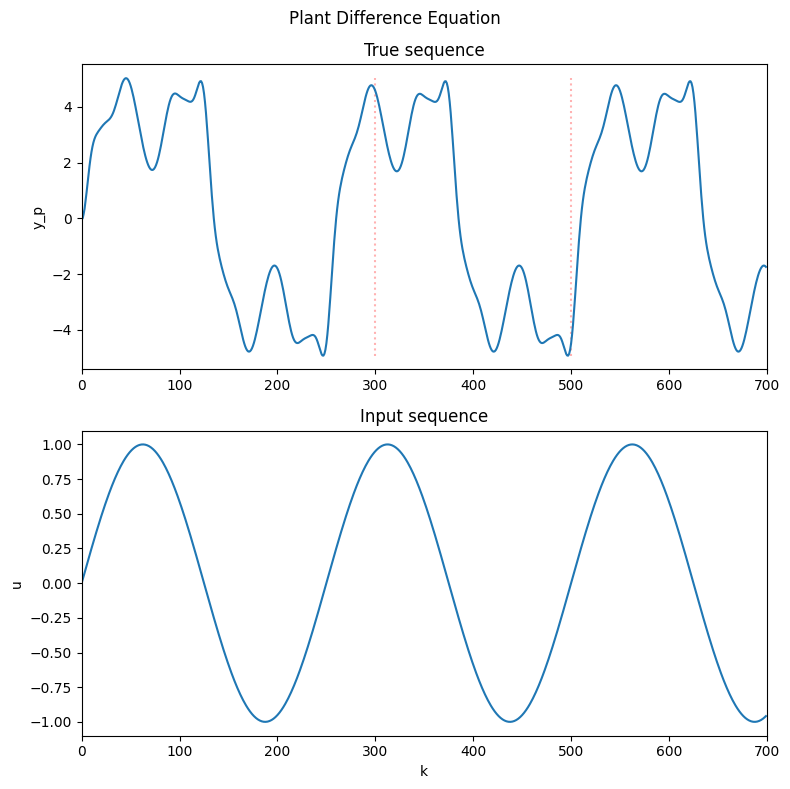

In [2]:
# sequence length (given in paper)
k_ = 700

# Sine wave input (given in paper)
u = np.sin(2 * np.pi * np.arange(k_) / 250)

# Plant non-linear function (given in paper)
def f(u):
    """Function f(u) from the paper."""
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(3 * np.pi * u) + 0.1 * np.sin(5 * np.pi * u)

def y(y_1: float, y_2: float, f: float) -> float:
    """Generate y(k) for the plant on a none-linear function.
    Note that since we are returning y at k (not k+1), we need to pass y_1 and y_2 that refer respectivly to y(k-1) and y(k-2).
    """
    return (0.3 * y_1) + (0.6 * y_2) + f
    

# init y true with assumed initial conditions (y(k=0)=0 and y(k=1)=0)
y_p = np.zeros(k_)

# Generate y_{p} (true sequence) for the plant on the function f(u).
for k in range(1, k_-1):
    y_p[k + 1] = y(y_p[k], y_p[k - 1], f(u[k]))
    # same as:
    # y_p[k+1] = 0.3 * y_p[k] + 0.6 * y_p[k - 1] + f(u[k])


fig, ax = plt.subplots(nrows=2, figsize=(8, 8))

fig.suptitle("Plant Difference Equation")

ax[0].vlines(x=300, ymin=min(y_p), ymax=max(y_p), colors="r", linestyles=":", alpha=0.3)
ax[0].vlines(x=500, ymin=min(y_p), ymax=max(y_p), colors="r", linestyles=":", alpha=0.3)

ax[0].plot(y_p)
ax[0].set_title("True sequence")
ax[0].set_ylabel("y_p")
ax[0].set_xlim([0, k_])

ax[1].plot(u)
ax[1].set_ylabel("u")
ax[1].set_xlabel("k")
ax[1].set_title("Input sequence")
ax[1].set_xlim([0, k_])
plt.tight_layout()
fig.savefig("plant_diff_eq.svg", dpi=300)
plt.show()

# Series-Parallel Model
The Neural Network is `N(u)` (as seen in the paper).

In [3]:
# System parameters
num_epochs = 1000
learning_rate = 0.25

# Initialize the neural network model N(u) to approximate f(u)
N = nn.Sequential(nn.Linear(1, 20),  nn.Tanh(),
                        nn.Linear(20, 10), nn.Tanh(),
                        nn.Linear(10, 1)
                        )

optimizer = optim.Adam(N.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


Each training step:
1. We provide the network inputs `u(k)`, to get the output `N(u)`.
2. We then pass `N(u)` to `y_hat[k + 1] = y(y_p[k], y_p[k - 1], N(u))`. Note that since this is a "Series-Parallel Model", we are passing the actuall $y_{p}(k-1)$ and $y_{p}(k-2)$ with our network $N(u)$ approximation.

In [4]:
# make tensors
u_ = torch.from_numpy(u).view(-1,1).float()
y_p_ = torch.from_numpy(y_p).float()


In [5]:
# prepare input data
y_hat = np.zeros(k_)
tr_loss = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    # Note that we don't have mini-batches, meaning that we will update the model after each time step
    for k in range(2, k_):
        optimizer.zero_grad()

        # Compute network approximation for f(u) and full prediction for y_p(k)
        f_pred = N(u_[k])
        y_hat_ = y(y_p_[k - 1], y_p_[k - 2], f_pred).squeeze()
        y_hat[k] = y_hat_.detach().numpy()

        # Compute the loss and backpropagate
        loss = criterion(y_hat_, y_p_[k])
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        epoch_loss += loss.item()
        tr_loss.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / (k_ - 2):.5f}')


Epoch 0, Loss: 0.02443
Epoch 100, Loss: 0.00423
Epoch 200, Loss: 0.00416
Epoch 300, Loss: 0.00420
Epoch 400, Loss: 0.00421
Epoch 500, Loss: 0.00419
Epoch 600, Loss: 0.00422
Epoch 700, Loss: 0.00421
Epoch 800, Loss: 0.00419
Epoch 900, Loss: 0.00424


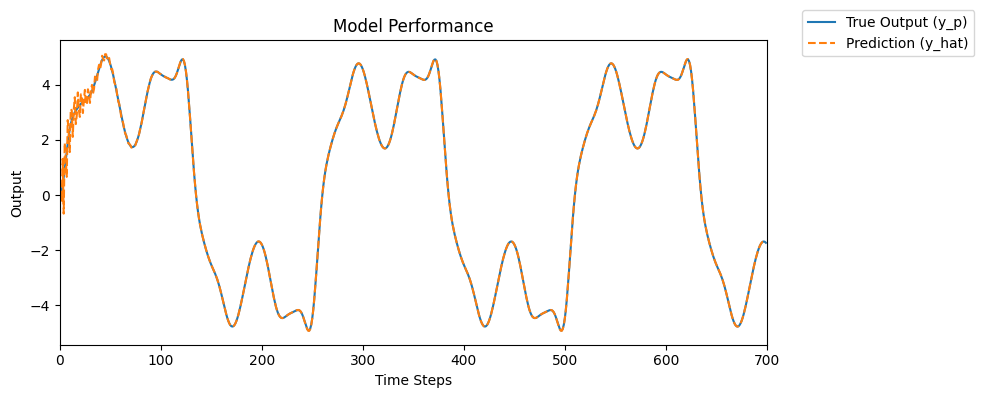

In [6]:
# Plot results to check model performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_p, label='True Output (y_p)')
ax.plot(y_hat, label='Prediction (y_hat)', linestyle='dashed')

ax.set_title('Model Performance')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Output')
ax.set_xlim([0, k_])

fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("model_performance.svg", dpi=30, bbox_inches="tight")
plt.show()


# Changing the $f(u)$

the new nonlinear function is:

$f(u) = u^{3} + 0.3u^{2} - 0.4u$

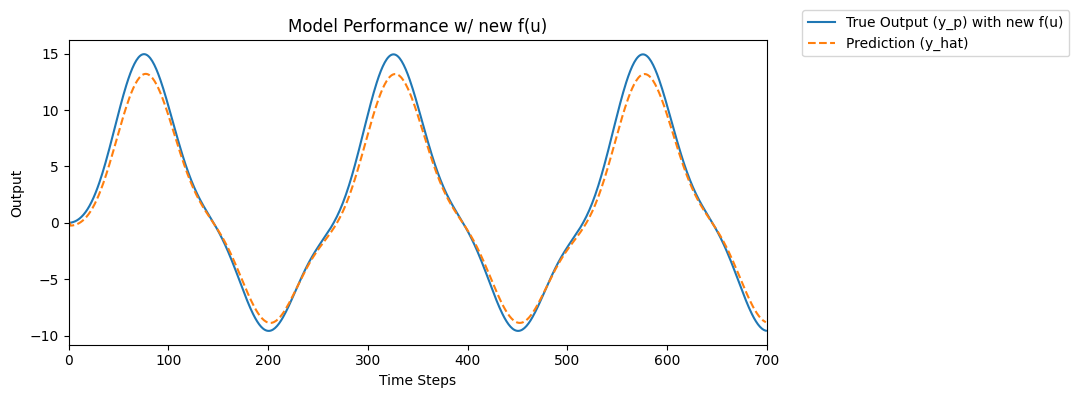

In [10]:
def f(u):
    """Function f(u) from the paper."""
    return np.power(u, 3) + 0.3 * np.power(u, 2) + 0.4 * u

# Generate y_{p} (true sequence) for the plant on the function f(u).
for k in range(1, k_ - 1):
    y_p[k + 1] = y(y_p[k], y_p[k - 1], f(u[k]))

y_hat = np.zeros(k_)

# make tensors
u_ = torch.from_numpy(u).view(-1, 1).float()
y_p_ = torch.from_numpy(y_p).float()

for k in range(2, k_):
    f_pred = N(u_[k])
    y_hat_ = y(y_p_[k - 1], y_p_[k - 2], f_pred).squeeze()
    y_hat[k] = y_hat_.detach().numpy()

# Plot results to check model performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_p, label="True Output (y_p) with new f(u)")
ax.plot(y_hat, label="Prediction (y_hat)", linestyle="dashed")

ax.set_title("Model Performance w/ new f(u)")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Output")
ax.set_xlim([0, k_])

fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("model_performance_new_f.svg", dpi=30, bbox_inches="tight")
plt.show()


# Changing $u(k)$

$u(k) = \sin(2\pi k / 250) + \sin(2 \pi k / 25)$

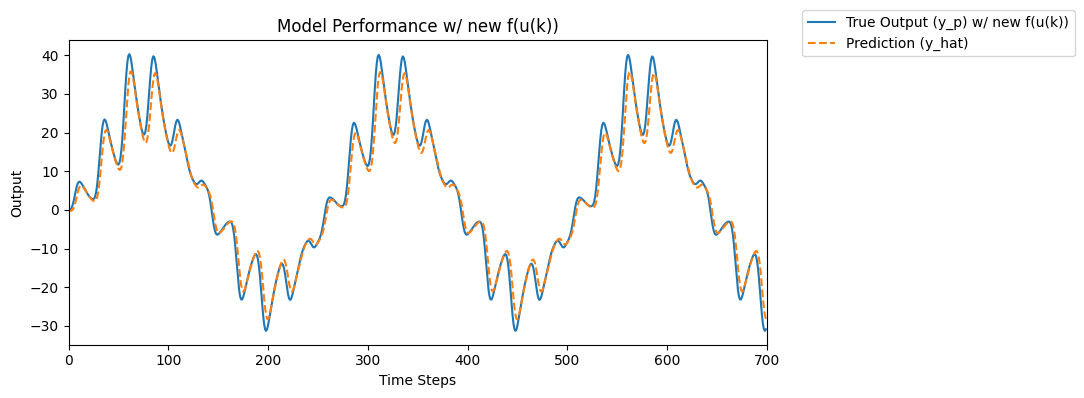

In [13]:
# Sine wave input (given in paper)
u = np.sin(2 * np.pi * np.arange(k_) / 250) + np.sin(2 * np.pi * np.arange(k_) / 25)

# Generate y_{p} (true sequence) for the plant on the function f(u).
for k in range(1, k_ - 1):
    y_p[k + 1] = y(y_p[k], y_p[k - 1], f(u[k]))

y_hat = np.zeros(k_)

# make tensors
u_ = torch.from_numpy(u).view(-1, 1).float()
y_p_ = torch.from_numpy(y_p).float()

for k in range(2, k_):
    f_pred = N(u_[k])
    y_hat_ = y(y_p_[k - 1], y_p_[k - 2], f_pred).squeeze()
    y_hat[k] = y_hat_.detach().numpy()

# Plot results to check model performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_p, label="True Output (y_p) w/ new f(u(k))")
ax.plot(y_hat, label="Prediction (y_hat)", linestyle="dashed")

ax.set_title("Model Performance w/ new f(u(k))")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Output")
ax.set_xlim([0, k_])

fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("model_performance_new_f_u.svg", dpi=30, bbox_inches="tight")
plt.show()


# Parallel Model
Trying this out

In [14]:
# prepare input data
y_hat = np.zeros(k_)
tr_loss = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    # Note that we don't have mini-batches, meaning that we will update the model after each time step
    for k in range(2, k_):
        optimizer.zero_grad()

        # Compute network approximation for f(u) and full prediction for y_p(k)
        f_pred = N(u_[k])
        y_hat_ = y(y_hat[k - 1], y_hat[k - 2], f_pred).squeeze()
        y_hat[k] = y_hat_.detach()

        # Compute the loss and backpropagate
        loss = criterion(y_hat_, y_p_[k])
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        epoch_loss += loss.item()
        tr_loss.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / (k_ - 2):.5f}")


Epoch 0, Loss: 51646.32767
Epoch 100, Loss: 16594.78119
Epoch 200, Loss: 14616.75165
Epoch 300, Loss: 8893.84631
Epoch 400, Loss: 8036.17048
Epoch 500, Loss: 8495.02891
Epoch 600, Loss: 8619.74022
Epoch 700, Loss: 8632.73476
Epoch 800, Loss: 8633.60898
Epoch 900, Loss: 8633.62628


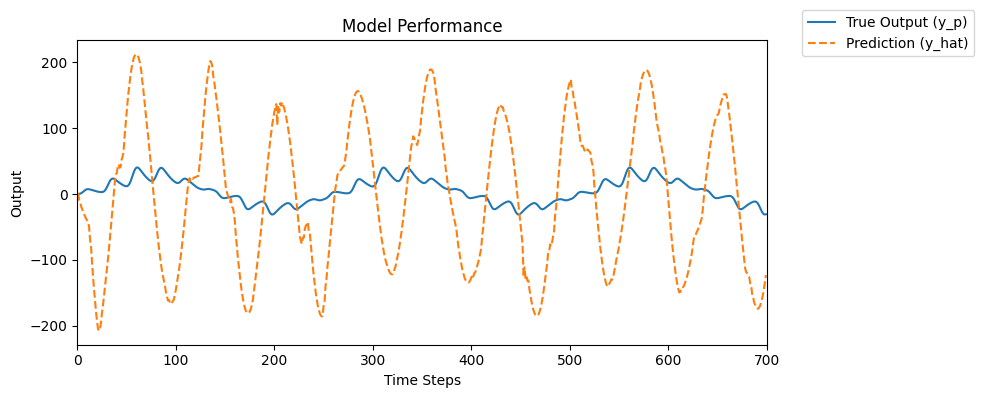

In [15]:
# Plot results to check model performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_p, label="True Output (y_p)")
ax.plot(y_hat, label="Prediction (y_hat)", linestyle="dashed")

ax.set_title("Model Performance")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Output")
ax.set_xlim([0, k_])

fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("parallel_model_performance.svg", dpi=30, bbox_inches="tight")
plt.show()
